# OpenFF Slow SMARTS Matching Example

An example bond parameter in a .offxml file is:
```
 <Bond smirks="[#6X4:1]-[#6X4:2]" id="b1" length="1.533682189836 * angstrom ** 1" k="430.4753865522 * kilocalorie_per_mole ** 1 * angstrom ** -2"></Bond>
```
The "SMIRKS" pattern is matched using the RDKit with [this function](https://github.com/openforcefield/openff-toolkit/blob/95a463fcefee3b1171c5e9c646682f323e6ff470/openff/toolkit/utils/rdkit_wrapper.py#L2762). However, this becomes extremely slow for large "SMIRKS" patterns where the molecule has lots of symmetry. This is expecially a problem for bespoke fitting code which generates highly specific SMARTS patterns which match large portions of/ entire molecules. For example:

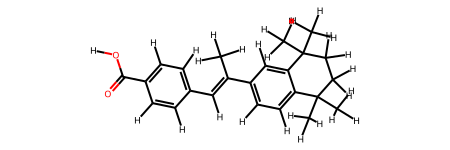

In [119]:
from openff.toolkit.utils.toolkits import RDKitToolkitWrapper
from openff.toolkit import Molecule
import numpy as np

SMILES = r'[H]c1c(c(c(c(c1/C(=C(/c2c(c(c3c(c2[H])C(C(C(C3(C([H])([H])[H])C([H])([H])[H])([H])[H])([H])[H])(C([H])([H])[H])C([H])([H])[H])[H])[H])\C([H])([H])[H])/[H])[H])[H])C(=O)O[H])[H]'
TAGGED_BOND_SMARTS = "[H]-[#6]1:[#6](:[#6](:[#6](:[#6:1](:[#6]:1/[#6](=[#6](/[#6]1:[#6](:[#6](:[#6]2:[#6](:[#6]:1-[H])-[#6](-[#6](-[#6](-[#6]-2(-[#6](-[H])(-[H])-[H])-[#6](-[H])(-[H])-[H])(-[H])-[H])(-[H])-[H])(-[#6](-[H])(-[H])-[H])-[#6](-[H])(-[H])-[H])-[H])-[H])-[#6](-[H])(-[H])-[H])-[H])-[H:2])-[H])-[#6](=[#8])-[#8]-[H])-[H]" # id="l-bespoke-91"

offmol = Molecule.from_smiles(SMILES)
rdmol = offmol.to_rdkit()
rdmol

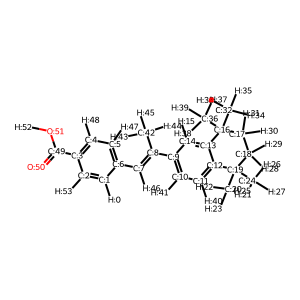

In [118]:
from rdkit.Chem import Draw
from IPython.display import SVG


def mol_with_atom_index(rdmol: Chem.Mol, width: int = 300, height: int = 300) -> str:

    # Build labels like "C:0", "C:1", "C:2", ...
    atom_labels = {
        atom.GetIdx(): f"{atom.GetSymbol()}:{atom.GetIdx()}"
        for atom in rdmol.GetAtoms()
    }

    drawer = Draw.MolDraw2DSVG(width, height)
    opts = drawer.drawOptions()
    for idx, label in atom_labels.items():
        opts.atomLabels[idx] = label

    Draw.rdMolDraw2D.PrepareAndDrawMolecule(drawer, rdmol)
    drawer.FinishDrawing()
    return drawer.GetDrawingText()


SVG(mol_with_atom_index(rdmol))

The tagged SMARTS matches two symmetry-related bonds:

In [125]:
matches = RDKitToolkitWrapper._find_smarts_matches(rdmol, TAGGED_BOND_SMARTS)
set(matches)

{(1, 0), (5, 47)}

However, it's far too slow:

In [126]:
%timeit RDKitToolkitWrapper._find_smarts_matches(rdmol, TAGGED_BOND_SMARTS)

2.07 s ± 247 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


How fast do we need to be? There are around ~ 400 valence parameters in this molecule, so we'll need to match approximately 400 bespoke tagged SMARTS for a bespoke force field. The current matching speed would give ~ 400 * 2 = 13 minutes for this molecule assuming `_find_smarts_matches` was the only contributor to parameterisation time. Aiming for ~ 1 s, we need each call to take ~ 3 ms or less.

We can get some speed improvement with `uniquify=True`, which has been [suggested to be fine for these valence parameters](https://github.com/openforcefield/openff-toolkit/pull/1036#issuecomment-895386608, as I understand it. This is much faster (especially using the [`_match_smarts_with_heavy_atoms_first` function](https://github.com/openforcefield/openff-toolkit/blob/95a463fcefee3b1171c5e9c646682f323e6ff470/openff/toolkit/utils/rdkit_wrapper.py#L2805)), although it's still too slow:

In [129]:
%timeit RDKitToolkitWrapper._find_smarts_matches(rdmol, TAGGED_BOND_SMARTS, unique=True)

219 ms ± 1.58 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


However, this neglects the symmetry-equivalent match so isn't usable:

In [130]:
matches = RDKitToolkitWrapper._find_smarts_matches(rdmol, TAGGED_BOND_SMARTS, unique=True)
set(matches)

{(5, 47)}

My understanding of the problem is that we end up with an exponential explosion in the number of possible substructure matches in `GetSubstructMatches` due to permutations of atoms we don't care about, because they don't affect the tagged atoms which identify the bond. 

In the case where a tagged SMARTS only matches one set of symmetry-equivalent bonds (we explicity construct tagged SMARTS so that this is True when bespoke fitting), a hacky solution is to find one match and then manually find any other matches by finding symmetry-equivalent locations only for the tagged atoms:

In [133]:
def _find_smarts_matches_tagged_atom_symmetry(
    rdmol: "Chem.Mol",
    smarts: str,
    aromaticity_model: str = "OEAroModel_MDL",
    unique: bool = False,
) -> list[tuple[int, ...]]:
    """
    Find all sets of atoms in the provided RDKit molecule that match the provided
    tagged SMARTS string. If the SMARTS is the same sinze as the molecule, we assume
    that there is only one set of symmetry-equivalent matches, we:

    1. Find a single match for the full SMARTS
    2. Get the symmetry classes for each atom in the molecule
    3. Find the other matches by considering only the symmetry of the tagged atoms

    Otherwise, we stick to default OpenFF behaviour.

    Parameters
    ----------
    rdmol
        RDKit molecule to search for matches
    smarts
        SMARTS string with sequentially tagged atoms (1..N)
    aromaticity_model
        OpenEye aromaticity model designation (only "OEAroModel_MDL" supported)
    unique
        Passed to RDKit's GetSubstructMatches as uniquify parameter

    Returns
    -------
    matches
        List of N-tuples of atom indices, one per unique chemical environment

    Raises
    ------
    ChemicalEnvironmentParsingError
        If the SMARTS string is malformed
    """
    from openff.toolkit.utils.exceptions import ChemicalEnvironmentParsingError
    from rdkit import Chem

    # Parse the SMARTS pattern
    qmol = Chem.MolFromSmarts(smarts)
    if qmol is None:
        raise ChemicalEnvironmentParsingError(
            f'RDKit could not parse the SMARTS/SMIRKS string "{smarts}"'
        )

    # Create atom mapping for query molecule
    idx_map: dict[int, int] = {}
    for atom in qmol.GetAtoms():  # type: ignore[no-untyped-call]
        smirks_index = atom.GetAtomMapNum()
        if smirks_index != 0:
            idx_map[smirks_index - 1] = atom.GetIdx()
    map_list = [idx_map[x] for x in sorted(idx_map)]

    # If the SMARTS pattern contains all atoms in the molecule, use symmetry-based matching
    if qmol.GetNumAtoms() == rdmol.GetNumAtoms():
        # Compute symmetry classes once - this is fast
        symmetry_ids = list(Chem.CanonicalRankAtoms(rdmol, breakTies=False))

        # Get only a single match and get the idxs of the atoms involved in the potential
        first_full_match = rdmol.GetSubstructMatches(
            qmol, uniquify=False, maxMatches=1, useChirality=True
        )[0]
        first_match = [first_full_match[x] for x in map_list]
        first_symmetry_ids = [symmetry_ids[x] for x in first_match]
        # Get a list of the number of bonds separating the matched atoms

        def get_shortest_bond_separation(
            rdmol: Chem.Mol, atom1: int, atom2: int
        ) -> int:
            return len(Chem.GetShortestPath(rdmol, atom1, atom2)) - 1

        bond_separations = {}  # Index is the index of the reference atom
        for i in range(1, len(first_match)):
            other_atoms = first_match[:i]
            bond_separations[i] = [
                get_shortest_bond_separation(rdmol, first_match[i], atom)
                for atom in other_atoms
            ]

        # Now, for each idx in symmetry_ids matching first_symmetry_ids, find the
        # next idx matching the next symmetry id which is the correct no of bonds away.
        # Do this recursively so it works for any length of match
        matched_idxs = []

        # TODO: Make this faster by only searching neighbours for the next atom
        def find_symmetric_matches(
            current_idx_in_first_symmetry_ids: int,
            current_match: list[int],
        ) -> None:
            # Base case: if we've matched all atoms, we're done
            if current_idx_in_first_symmetry_ids == len(first_symmetry_ids) - 1:
                matched_idxs.append(tuple(current_match))
                return

            # Find the next symmetry id to match
            next_sym_id = first_symmetry_ids[current_idx_in_first_symmetry_ids + 1]
            for i in range(len(symmetry_ids)):
                if not symmetry_ids[i] == next_sym_id:
                    continue

                if i in current_match:
                    continue

                current_bond_seps = [
                    get_shortest_bond_separation(rdmol, i, j) for j in current_match
                ]
                if (
                    not current_bond_seps
                    == bond_separations[current_idx_in_first_symmetry_ids + 1]
                ):
                    continue

                find_symmetric_matches(
                    current_idx_in_first_symmetry_ids + 1, current_match + [i]
                )

        first_idx_molecule_matches = [
            i
            for i in range(len(symmetry_ids))
            if symmetry_ids[i] == first_symmetry_ids[0]
        ]

        for molecule_idx in first_idx_molecule_matches:
            find_symmetric_matches(0, [molecule_idx])

        return matched_idxs

    # Otherwise, do not assume only one set of symmetry-equivalent matches
    # and use the original RDKit behavior (very slow for symmetric molecules
    # with large SMIRKS patterns)
    else:
        max_matches = np.iinfo(np.uintc).max
        full_matches = rdmol.GetSubstructMatches(
            qmol, uniquify=unique, maxMatches=max_matches, useChirality=True
        )
        matches = [tuple(match[x] for x in map_list) for match in full_matches]
        return matches


This is much faster, and fast enough for our purposes:

In [134]:
%timeit _find_smarts_matches_tagged_atom_symmetry(rmol, TAGGED_BOND_SMARTS)

670 μs ± 159 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Crucially, it also returns both symmetry-equivalent matches:

In [136]:
matches = _find_smarts_matches_tagged_atom_symmetry(rdmol, TAGGED_BOND_SMARTS)
set(matches)

{(1, 0), (5, 47)}

However, this only works when there is only one set of symmetry-equivalent matches for the tagged atoms. It would be nice to have a speed up where the tagged SMARTS are large but we can't guarantee this.

Does anyone have any suggestions on how to do this? Have I missed anything trivial in RDKit?

Thanks very much.